# CSI4142 - Data Science

## Assignment 3 - Predictive analysis - Regression and Classification

Shacha Parker 300235525

Callum Frodsham 300199446

Group 79

This part of the assignment takes a dataset and performs an empirical study with a linear regression task.

#### Execution of the Notebook

Execution of the notebook requires a recent version of Python and a virtual environment if your operating system requires it.

You also need the following libraries installed for import dependencies: numpy, pandas, seaborn, matplotlib, and sklearn.
### Dataset Information
Dataset name: <a href="https://www.kaggle.com/datasets/mirichoi0218/insurance">Medical Cost Personal Datasets</a>
<br>
Provider: Miri Choi on Kaggle

<b>Features</b>

    age: age of primary beneficiary - quantitative - continuous

    sex: insurance contractor gender, female, male - categorical, ordinal

    bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9 - quantitative - continuous

    children: Number of children covered by health insurance / Number of dependents - quantitative, discrete

    smoker: does the beneficiary smoke - categorical, nominal

    region: the beneficiary's residential area in the US: northeast, southeast, southwest, northwest. - categorical, nominal

    charges: Individual medical costs billed by health insurance - quantitative, continuous


In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load the dataset
# CHANGE THIS TO GITHUB RAW
data = pd.read_csv("https://raw.githubusercontent.com/ShackuOttawa/Assignment3CSI4142/refs/heads/main/insurance.csv")

# output settings for debugging
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data Cleaning
The dataset is already clean. This can be seen with the results of the code cell below: no entries are null, and all values are appropriate. No cleaning is needed.

In [2]:
print(data.info())
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Display unique values
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"\nUnique values in column '{column}':\n", data[column].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max

## Categorical Feature Encoding
Through the get_dummies function, we can create the dataset with all categorical features becoming one-hot vectors. The rest of the features remain as they were.

In [3]:
# One-hot encode the specified categorical features
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=False)

## EDA and Outlier detection
a. Outlier detection

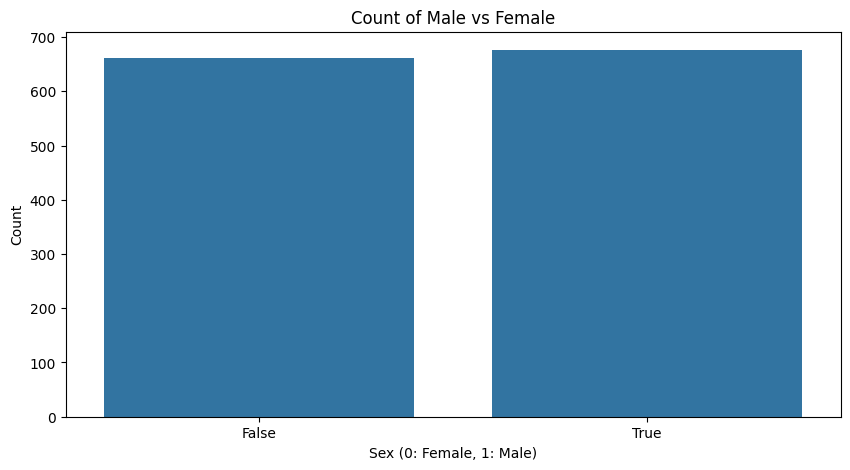

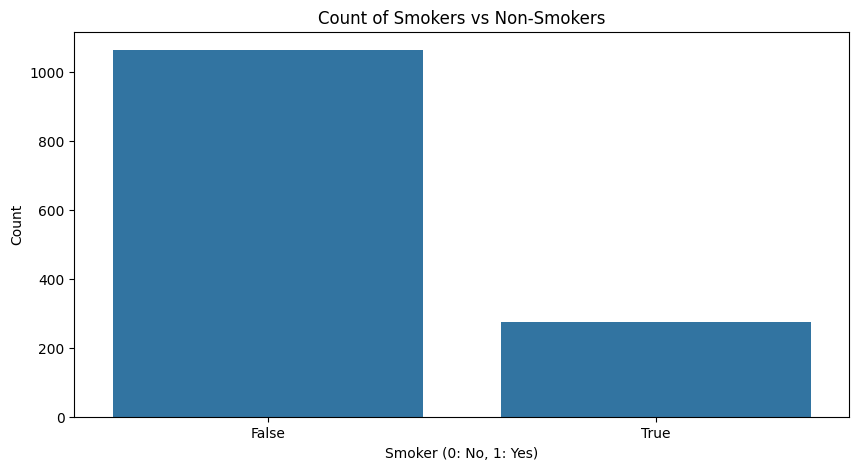

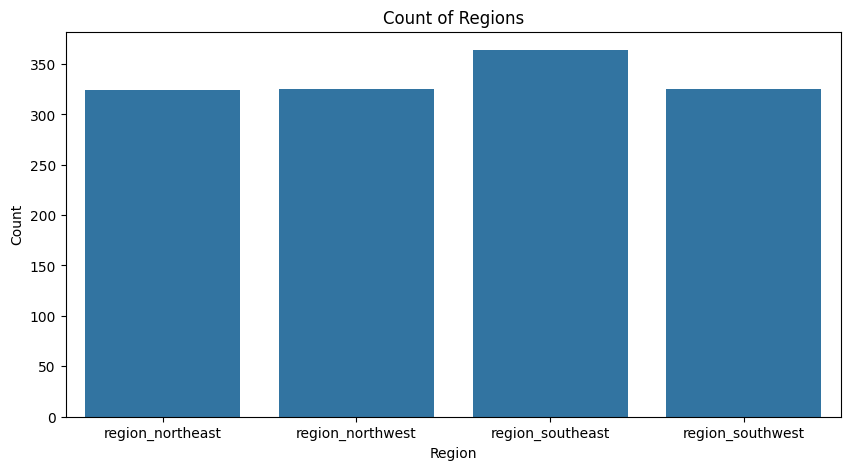

In [4]:
# Comparison graph for sex_male against sex_female
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='sex_male')
plt.title('Count of Male vs Female')
plt.xlabel('Sex (0: Female, 1: Male)')
plt.ylabel('Count')
plt.show()

# Comparison graph for smoker counts
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='smoker_yes')
plt.title('Count of Smokers vs Non-Smokers')
plt.xlabel('Smoker (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# Comparison for regions
plt.figure(figsize=(10, 5))
region_columns = ['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
region_counts = data[region_columns].sum()
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.title('Count of Regions')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

Naturally, outliers don't occur on categorical data like this.

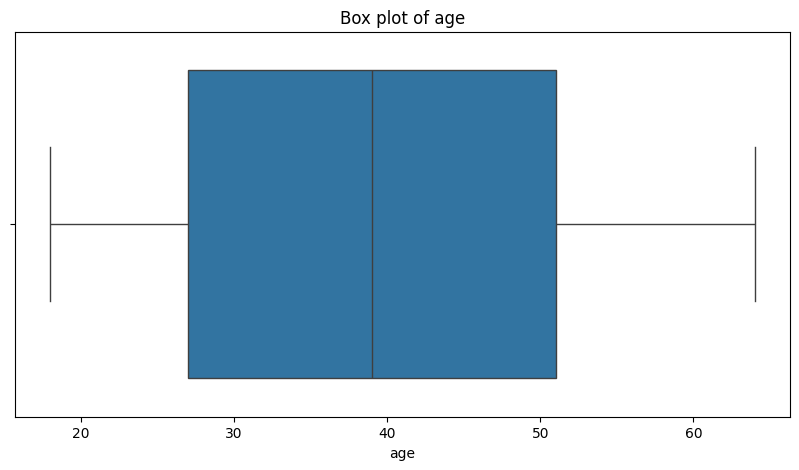

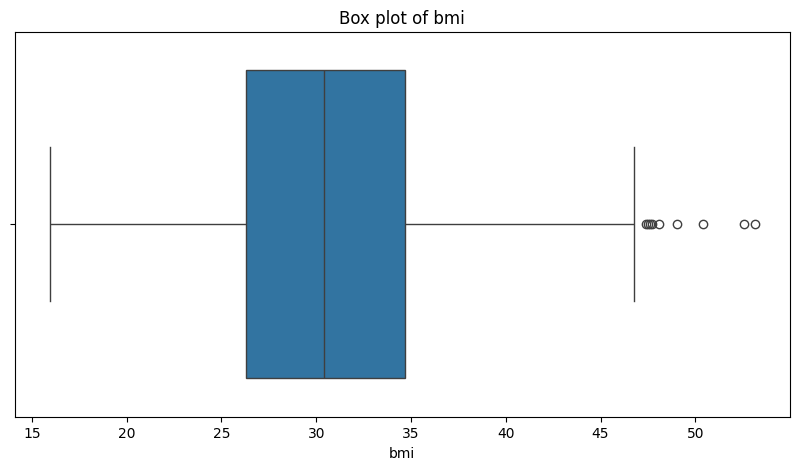

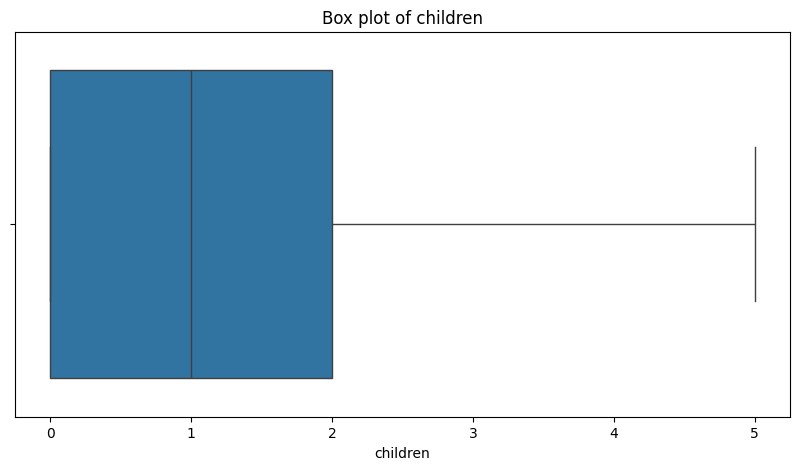

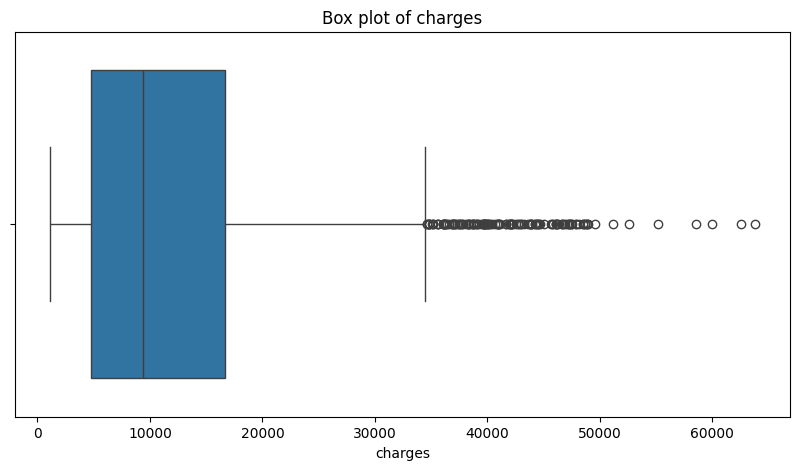

In [5]:
# Visualize all numerical features
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data, x=column)
    plt.title(f'Box plot of {column}')
    plt.show()

Since feature 'bmi' has only 9 outliers out of the 1000+ entries (0.67%), we can safely remove them without there being a significant statistical impact.

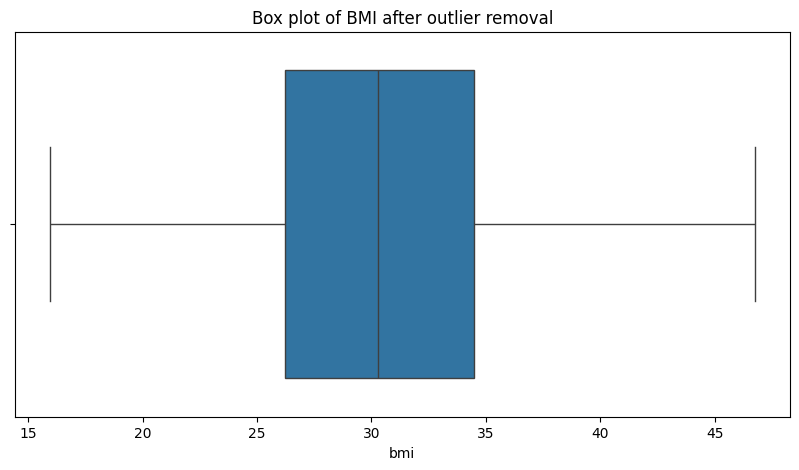

Original data shape: (1338, 12)
Data shape after removing outliers: (1329, 12)


In [6]:
data_without_outlier_removal = data.copy()
original = data.shape

Q1 = data['bmi'].quantile(0.25)
Q3 = data['bmi'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data = data[(data['bmi'] >= lower_bound) & (data['bmi'] <= upper_bound)]

plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x=data['bmi'])
plt.title(f'Box plot of BMI after outlier removal')
plt.show()

print("Original data shape:", original)
print("Data shape after removing outliers:", data.shape)

For the 'charges' outliers, it would negatively impact the dataset if all rows with 'charges' outliers were removed. Instead, we'll use  linear regression imputation to apply known values over the existing outlier values.

In [7]:
D2 = data.copy()

# Create LocalOutlierFactor, fit it to temporary dataframe D2, and remove outliers
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
D2['charges_outlier'] = lof.fit_predict(D2[['charges']])

D2.loc[D2['charges_outlier'] == -1, 'charges'] = np.nan
D2.drop(columns=['charges_outlier'], inplace=True)

print("Number of NaN values in 'charges' after outlier removal:", D2['charges'].isnull().sum())

Number of NaN values in 'charges' after outlier removal: 67


This imputation strategy is also a demonstration of my knowledge and exploration of sklearn's LinearRegression method for part d) Predictive analysis.

In [8]:
# Separate the features and target variable in the original data
X_original = data.drop(columns=['charges'])
y_original = data['charges']

# Train a linear regression model on the original data
imputation_model = LinearRegression()
imputation_model.fit(X_original, y_original)

# Identify the rows in D2 with missing 'charges' values
missing_indices = D2[D2['charges'].isnull()].index
X_missing = D2.loc[missing_indices].drop(columns=['charges'])

# Replace missing values through imputation prediction
imputed_values = imputation_model.predict(X_missing)
D2.loc[missing_indices, 'charges'] = imputed_values

missing_values_d2_after_imputation = D2['charges'].isnull().sum()
print("Missing values in 'charges' column of D2 after imputation:", missing_values_d2_after_imputation)

# Return D2 values to main dataframe
data = D2.copy()

Missing values in 'charges' column of D2 after imputation: 0


## Feature Engineering
Before we proceed with feature engineering, we'll create new copies of the dataset with and without outlier removal that will not have the extra features.

In [9]:
data_without_outlier_removal_or_FE = data_without_outlier_removal.copy()
data_without_FE = data.copy()

For the first new feature, we will create the age-bmi column. The age-bmi value is a row's age multiplied by its bmi, which is then normalized by dividing this number by the median age times the median bmi.

In [10]:
medianage = data['age'].median()
medianbmi = data['bmi'].median()
data['age-bmi'] = (data['age'] * data['bmi']) / (medianage * medianbmi)
data_without_outlier_removal_with_FE = data_without_outlier_removal
data_without_outlier_removal_with_FE['age-bmi'] = (data_without_outlier_removal['age'] * data_without_outlier_removal['bmi']) / (medianage * medianbmi)

Secondly, we'll create a feature called "childandsmoker" which is a boolean value that is true if the row has a positive number of children and 'smoker' is 'yes'.

In [11]:
data['childandsmoker'] = np.where((data['smoker_yes'] == True) & (data['children'] > 0), True, False)
data_without_outlier_removal_with_FE['childandsmoker'] = np.where((data_without_outlier_removal_with_FE['smoker_yes'] == True) & (data_without_outlier_removal_with_FE['children'] > 0), True, False)

In [12]:
# Renaming these variables to be more legible
data_with_both = data
data_with_neither = data_without_outlier_removal_or_FE
data_with_FE = data_without_outlier_removal_with_FE
data_with_OR = data_without_FE

At this point, we have:

*data_with_both*: the data with both outliers removed and new features engineered.

*data_with_neither*: data with neither outliers removed nor feature engineering

*data_with_FE*: data including outliers without feature engineering applied

*data_with_OR*: data with outliers removed but without feature engineering

## Empirical study

First, we split each dataset into train, validation, and test sets.

In [13]:
# Split the data_with_both dataset
data_with_both_train, data_with_both_temp = train_test_split(data_with_both, test_size=0.3, random_state=0)
data_with_both_validation, data_with_both_test = train_test_split(data_with_both_temp, test_size=0.5, random_state=0)

# Split the data_with_neither dataset
data_with_neither_train, data_with_neither_temp = train_test_split(data_with_neither, test_size=0.3, random_state=0)
data_with_neither_validation, data_with_neither_test = train_test_split(data_with_neither_temp, test_size=0.5, random_state=0)

# Split the data_with_FE dataset
data_with_FE_train, data_with_FE_temp = train_test_split(data_with_FE, test_size=0.3, random_state=0)
data_with_FE_validation, data_with_FE_test = train_test_split(data_with_FE_temp, test_size=0.5, random_state=0)

# Split the data_with_OR dataset
data_with_OR_train, data_with_OR_temp = train_test_split(data_with_OR, test_size=0.3, random_state=0)
data_with_OR_validation, data_with_OR_test = train_test_split(data_with_OR_temp, test_size=0.5, random_state=0)

In [14]:
# Function that 
def evaluate_model(X_train, y_train, X_val, y_val, info):
    # Initialize the linear regression model
    model = LinearRegression()

    # Perform 4-fold cross-validation on the training set
    kf = KFold(n_splits=4, shuffle=True, random_state=0)
    mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    # Fit and then train the model on the designated train set
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)

    # Calculate MSE and R2 on the validation set
    mse_val = mean_squared_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)

    # Print the results
    print("Results for", info)
    print("Cross-validated MSE scores:", -mse_scores)
    print("Cross-validated R2 scores:", r2_scores)
    print("Mean cross-validated MSE:", -mse_scores.mean())
    print("Mean cross-validated R2:", r2_scores.mean())
    print("Validation MSE:", mse_val)
    print("Validation R2:", r2_val)

#### Evaluation and Results

In [15]:
X_train = data_with_neither_train.drop(columns=['charges'])
y_train = data_with_neither_train['charges']
X_val = data_with_neither_validation.drop(columns=['charges'])
y_val = data_with_neither_validation['charges']

evaluate_model(X_train, y_train, X_val, y_val, "data_with_neither")

Results for data_with_neither
Cross-validated MSE scores: [35544580.28867318 48510404.7545211  34701680.93947544 35974950.08501023]
Cross-validated R2 scores: [0.71382975 0.69395974 0.74788357 0.74770682]
Mean cross-validated MSE: 38682904.016919985
Mean cross-validated R2: 0.7258449678474086
Validation MSE: 30516232.24545545
Validation R2: 0.8179101067581979


In [16]:
X_train = data_with_OR_train.drop(columns=['charges'])
y_train = data_with_OR_train['charges']
X_val = data_with_OR_validation.drop(columns=['charges'])
y_val = data_with_OR_validation['charges']

evaluate_model(X_train, y_train, X_val, y_val, "data_with_OR")

Results for data_with_OR
Cross-validated MSE scores: [31784533.62464507 35731203.19553205 27412425.49279809 31342865.62516407]
Cross-validated R2 scores: [0.75262768 0.73477756 0.77541741 0.75883238]
Mean cross-validated MSE: 31567756.98453482
Mean cross-validated R2: 0.7554137540992083
Validation MSE: 31349711.22008278
Validation R2: 0.7834747288804369


In [17]:
X_train = data_with_FE_train.drop(columns=['charges'])
y_train = data_with_FE_train['charges']
X_val = data_with_FE_validation.drop(columns=['charges'])
y_val = data_with_FE_validation['charges']

evaluate_model(X_train, y_train, X_val, y_val, "data_with_FE")

Results for data_with_FE
Cross-validated MSE scores: [35489331.10264202 50169991.10119096 35409922.8165771  35732457.76033678]
Cross-validated R2 scores: [0.71427456 0.68348981 0.74273801 0.74940742]
Mean cross-validated MSE: 39200425.69518672
Mean cross-validated R2: 0.722477452310874
Validation MSE: 31173704.07605363
Validation R2: 0.8139869823541049


In [18]:
X_train = data_with_both_train.drop(columns=['charges'])
y_train = data_with_both_train['charges']
X_val = data_with_both_validation.drop(columns=['charges'])
y_val = data_with_both_validation['charges']

evaluate_model(X_train, y_train, X_val, y_val, "data_with_both")

Results for data_with_both
Cross-validated MSE scores: [31811708.18729039 35878890.07206871 27641277.92158115 31468003.84780518]
Cross-validated R2 scores: [0.75241618 0.73368132 0.77354248 0.7578695 ]
Mean cross-validated MSE: 31699970.007186353
Mean cross-validated R2: 0.7543773708436179
Validation MSE: 31518440.095689643
Validation R2: 0.782309357203486


It seems that the best performance is with the data with neither OR or FE applied, by a very small margin. We will use this now to run the test set.

In [19]:
X_train = data_with_neither_train.drop(columns=['charges'])
y_train = data_with_neither_train['charges']
# Prepare the test data for data_with_neither
X_test_neither = data_with_neither_test.drop(columns=['charges'])
y_test_neither = data_with_neither_test['charges']

# Evaluate the model on the test dataset for data_with_neither
evaluate_model(X_train, y_train, X_test_neither, y_test_neither, "data_with_neither (Test Set)")

Results for data_with_neither (Test Set)
Cross-validated MSE scores: [35544580.28867318 48510404.7545211  34701680.93947544 35974950.08501023]
Cross-validated R2 scores: [0.71382975 0.69395974 0.74788357 0.74770682]
Mean cross-validated MSE: 38682904.016919985
Mean cross-validated R2: 0.7258449678474086
Validation MSE: 36168763.40845369
Validation R2: 0.7607863782961922


Let's now run the tests on the other models.

In [20]:
X_train = data_with_FE_train.drop(columns=['charges'])
y_train = data_with_FE_train['charges']
X_test = data_with_FE_test.drop(columns=['charges'])
y_test = data_with_FE_test['charges']

# Evaluate the model on the test dataset for data_with_FE
evaluate_model(X_train, y_train, X_test, y_test, "data_with_FE (Test Set)")
print()

X_train = data_with_OR_train.drop(columns=['charges'])
y_train = data_with_OR_train['charges']
X_test_OR = data_with_OR_test.drop(columns=['charges'])
y_test_OR = data_with_OR_test['charges']

# Evaluate the model on the test dataset for data_with_OR
evaluate_model(X_train, y_train, X_test_OR, y_test_OR, "data_with_OR (Test Set)")
print()

X_train = data_with_both_train.drop(columns=['charges'])
y_train = data_with_both_train['charges']
X_test_both = data_with_both_test.drop(columns=['charges'])
y_test_both = data_with_both_test['charges']

# Evaluate the model on the test dataset for data_with_both
evaluate_model(X_train, y_train, X_test_both, y_test_both, "data_with_both (Test Set)")

Results for data_with_FE (Test Set)
Cross-validated MSE scores: [35489331.10264202 50169991.10119096 35409922.8165771  35732457.76033678]
Cross-validated R2 scores: [0.71427456 0.68348981 0.74273801 0.74940742]
Mean cross-validated MSE: 39200425.69518672
Mean cross-validated R2: 0.722477452310874
Validation MSE: 36277723.78821877
Validation R2: 0.7600657341654687

Results for data_with_OR (Test Set)
Cross-validated MSE scores: [31784533.62464507 35731203.19553205 27412425.49279809 31342865.62516407]
Cross-validated R2 scores: [0.75262768 0.73477756 0.77541741 0.75883238]
Mean cross-validated MSE: 31567756.98453482
Mean cross-validated R2: 0.7554137540992083
Validation MSE: 39294089.97540011
Validation R2: 0.7483326943539468

Results for data_with_both (Test Set)
Cross-validated MSE scores: [31811708.18729039 35878890.07206871 27641277.92158115 31468003.84780518]
Cross-validated R2 scores: [0.75241618 0.73368132 0.77354248 0.7578695 ]
Mean cross-validated MSE: 31699970.007186353
Mean cr

## Result Analysis
Across the different dataset variations, the dataset with neither outlier removal nor feature engineering did indeed turn out to have the best scores (lowest MSE, highest R2) of the 4. It's worth noting that the difference in some scores was quite marginal. I tried the train_test_split again with a random value of 42 for all splits, and the feature engineering dataset was slightly higher, but almost in a near tie with the data_with_neither dataset in training/validation. However, when applied to testing, it turned out to be unexpectedly worse in scores than the other datasets. In my tests, I believe that outlier detection and removal generally worsened results slightly, while feature engineering had a neutral-to-positive effect, making it about equal to the dataset with neither technique applied. Interestingly, I found that in many tests, applying both techniques (data_with_both) consistently gave the worst scores of all. In the currently-set state, the results of the unseen tests lined up as expected with the cross-validation training/validations. I find this will typically be the case, but because the scores are so close to each other, it's possible some certain random configurations may cause unexpected results between the validation and the unseen tests. If I could have been more comprehensive beyond the scope of this assignment, I would do more tests, iterating through a series of random numbers for the train/test split seed, and take the mean of the results from them to better determine the most accurate results.

## References
<a href="https://numpy.org/doc/2.2/user/index.html#user">Numpy Documentation</a>

<a href="https://pandas.pydata.org/docs/">Pandas Documentation</a>

<a href="https://seaborn.pydata.org/tutorial/introduction.html">Seaborn Tutorial</a>

<a href="https://matplotlib.org/stable/users/index.html">Matplotlib User Guide</a>

<a href="https://scikit-learn.org/stable/api/index.html">Scikit-Learn API</a>